# Price evolution prediction

#### To predict the evolution of the price per neighboorhood we need to have an historical dataset. To do that, first we have to scrap the website and download all the files available for Madrid.

### Scrapping 

In [78]:
import requests
from bs4 import BeautifulSoup

In [79]:
url = "http://insideairbnb.com/get-the-data.html"
r = requests.get(url)
r.status_code

200

In [80]:
soup = BeautifulSoup(r.text)
path = r'C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos\Historico'

In [81]:
for link in soup.findAll('a', href=True):
  if ('madrid' in link['href']) and ('visualisations/listings.csv' in link['href']):
    #print(link['href'])
    csv_url = link['href']
    req = requests.get(csv_url)
    url_content = req.content
    nombre = csv_url[61:69].replace("-", "_")
    #To save the file in a folder
    csv_file = open(path + nombre + '.csv', 'wb')
    csv_file.write(url_content)
    csv_file.close()

### Historical dataset creation

In [82]:
import pickle
import pandas as pd
from datetime import datetime
import numpy as np

In [83]:
def outliers(data, column):
    # First quartile (Q1)
    Q1 = np.percentile(data[column], 25)
    # Third quartile (Q3)
    Q3 = np.percentile(data[column], 75)
    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    down = Q1 - 1.5*IQR
    up =   Q3 + 1.5*IQR
    return dataset.loc[(data[column] < down) | (data[column] > up),
                column].index.values

In [84]:
path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos\Historico"
info = pd.read_csv(path + "/2020_07.csv", quotechar='"', engine = "python", encoding = "utf8")
info = info[["id", "price"]]
info.rename(columns = {'price':'2020_07'}, inplace=True)

#### Now we have to unify all files to marge the rpice columns per file:

In [85]:
import os
directory = os.path.join(path)
for root,dirs,files in os.walk(directory):
    for file in files:
       if file.endswith(".csv"):
           print(file)
           hist = pd.read_csv(path + "/" + file , quotechar='"', engine = "python", encoding = "utf8")
           hist = hist[["id", "price"]]
           hist["price"].astype(int)
           hist.rename(columns = {'price':file[:-4]}, inplace=True)
           info = pd.merge(hist, info, 
                           left_on='id', right_on='id', how='outer')

info.drop(columns = ["2020_07_y"], inplace = True)
info.rename(columns = {'2020_07_x':'2020_07'}, inplace=True)
media = info

2015_07.csv
2015_09.csv
2015_10.csv
2017_03.csv
2017_04.csv
2018_01.csv
2018_04.csv
2018_05.csv
2018_07.csv
2018_08.csv
2018_09.csv
2018_10.csv
2018_11.csv
2018_12.csv
2019_01.csv
2019_02.csv
2019_03.csv
2019_04.csv
2019_05.csv
2019_06.csv
2019_07.csv
2019_08.csv
2019_09.csv
2019_10.csv
2019_11.csv
2019_12.csv
2020_01.csv
2020_02.csv
2020_03.csv
2020_04.csv
2020_05.csv
2020_06.csv
2020_07.csv


#### We need to add more information to the dataset, such as the neighbourhood name and the room type:

In [86]:
nombre = info.columns[1]
caract = pd.read_csv(path + "\\" + nombre  + ".csv", quotechar='"', engine = "python", encoding = "utf8")
media = pd.merge(media, caract[["id", "neighbourhood_group", "room_type"]], 
                               on=['id'] , how='left')

#### Let's create a dataset with the mean prices per neighbourhood and room type:

In [87]:
for col in range(2, info.shape[1]-2):
    nombre = info.columns[col]
    caract = pd.read_csv(path + "\\" + nombre  + ".csv", quotechar='"', engine = "python", encoding = "utf8")
    media = pd.merge(media, caract[["id", "neighbourhood_group", "room_type"]], 
                               on=['id'] , how='left')
    media['neigh'] = media['neighbourhood_group_x'].where(media['neighbourhood_group_x'].notnull(), media['neighbourhood_group_y'])
    media.drop(columns = ['neighbourhood_group_x','neighbourhood_group_y'],axis=1,inplace=True)
    media['room'] = media['room_type_x'].where(media['room_type_x'].notnull(), media['room_type_y'])
    media.drop(columns = ['room_type_x','room_type_y'],axis=1, inplace=True)
    media.rename(columns = {'neigh':'neighbourhood_group'}, inplace=True)
    media.rename(columns = {'room':'room_type'}, inplace=True)

In [88]:
dataset = media
dataset = pd.melt(dataset, id_vars=["id", "neighbourhood_group", "room_type"], var_name=["date"])
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y_%m")
dataset.dropna(inplace=True)
dataset = dataset.loc[dataset["value"] > 1, :]
dataset.drop(index=outliers(dataset, "value"), inplace=True)

In [89]:
dataset.head()

,id,neighbourhood_group,room_type,date,value
0,6369,Chamartín,Private room,2020-07-01,70.0
1,21853,Latina,Private room,2020-07-01,30.0
2,23001,Arganzuela,Entire home/apt,2020-07-01,50.0
3,24805,Centro,Entire home/apt,2020-07-01,89.0
4,24836,Centro,Entire home/apt,2020-07-01,115.0


#### Let's save the dataset to use it later:

In [90]:
with open(r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos\Pickles\hist_data.pk", "wb") as file:
    pickle.dump(dataset, file)

### Price evolution prediction

In [91]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

In [92]:
with open(r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\Datos\Pickles\hist_data.pk", "rb") as file:
    dataset = pickle.load(file)
barrios = list(dataset["neighbourhood_group"].unique())

#### We will split the dataset basec on the room type, since the price is significantly different:

In [93]:
apt_dataset = dataset[dataset["room_type"] == "Entire home/apt"]
room_dataset = dataset[dataset["room_type"] == ("Private room" or "Shared room")]
save_path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\assets"

#### Apartments

In [94]:
df_apt = apt_dataset.groupby("date").mean()
df_apt = df_apt.reset_index()
df_apt=df_apt[['date','value']]
df_apt.dropna(inplace=True)

#### Let's use seaborn to represent the graph:

(array([736876., 736968., 737060., 737150., 737241., 737333., 737425.,
        737516.]),
 <a list of 8 Text xticklabel objects>)

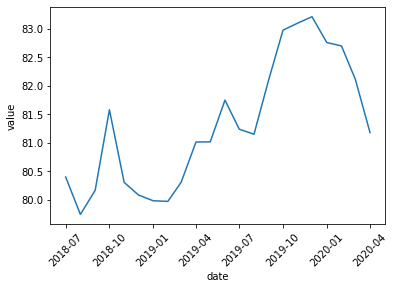

In [95]:
df_apt = df_apt.loc[df_apt["date"] > '2018-06-01', :]
df_apt = df_apt.loc[df_apt["date"] < '2020-05-01', :]
apt_plot = sns.lineplot(data=df_apt, x="date", y="value")
plt.xticks(rotation=45)

#### We will use Prophet to predict the apartment's price evolution in Madrid:

In [96]:
df_apt['ds']=df_apt['date']
df_apt['y']=df_apt['value']
df_apt.drop(columns = ['date', 'value'], inplace = True)   
m = Prophet(weekly_seasonality=True)
m.fit(df_apt)

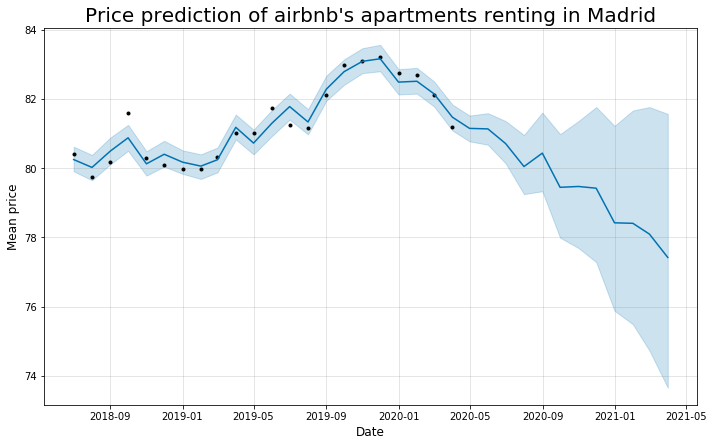

In [97]:
future_apt = m.make_future_dataframe(periods=12, 
                                 freq="M") # days for test split
future_apt.tail()
forecast_apt = m.predict(future_apt)
fig_apt = m.plot(forecast_apt)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean price', fontsize=12)
plt.title("Price prediction of airbnb's apartments renting in Madrid", {'fontsize': 20})
plt.savefig("{}.png".format(save_path + "\\apt_madrid"), bbox_inches='tight')

#### Let's predict the apartment's evolution price per neighbourhood, which should be more precise:

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

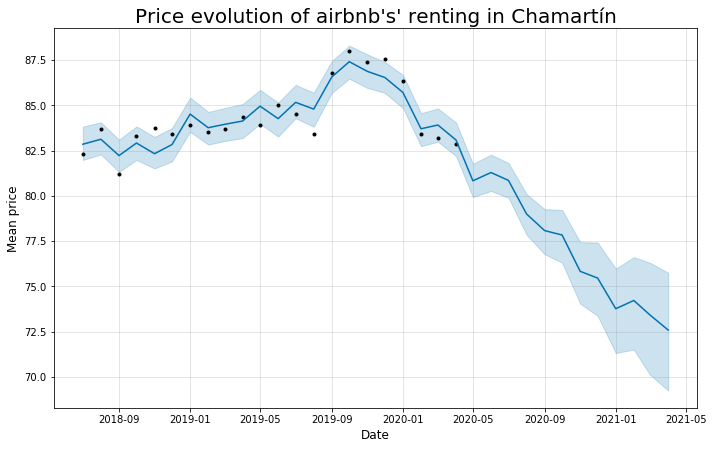

<Figure size 1440x720 with 0 Axes>

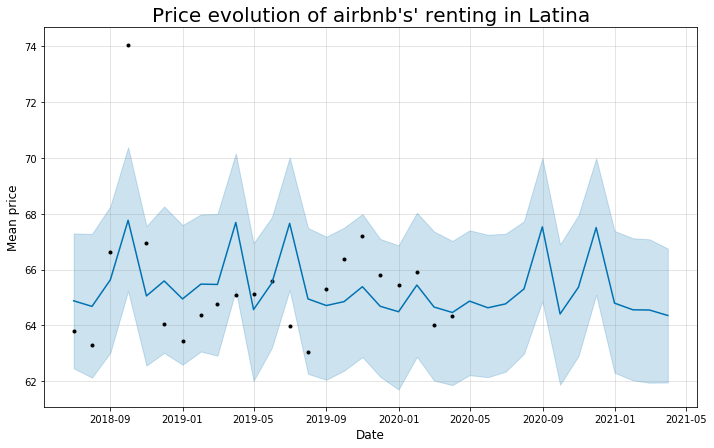

<Figure size 1440x720 with 0 Axes>

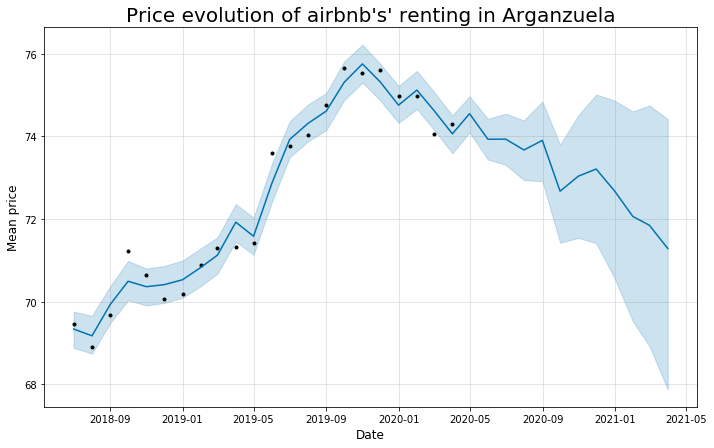

<Figure size 1440x720 with 0 Axes>

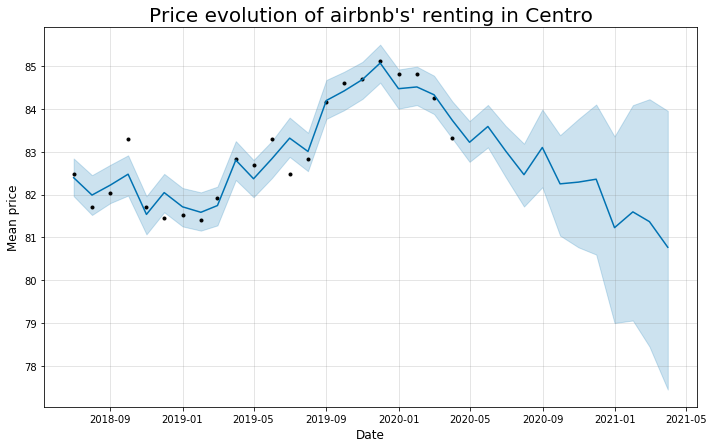

<Figure size 1440x720 with 0 Axes>

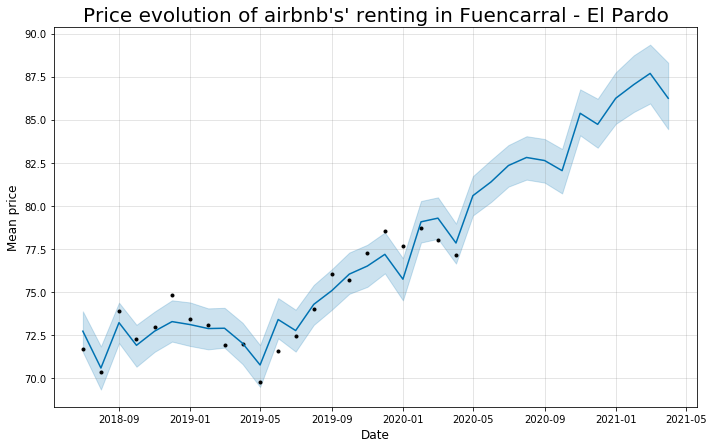

<Figure size 1440x720 with 0 Axes>

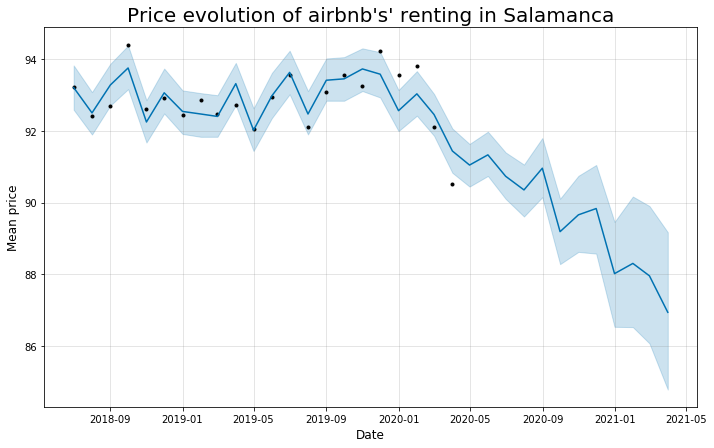

<Figure size 1440x720 with 0 Axes>

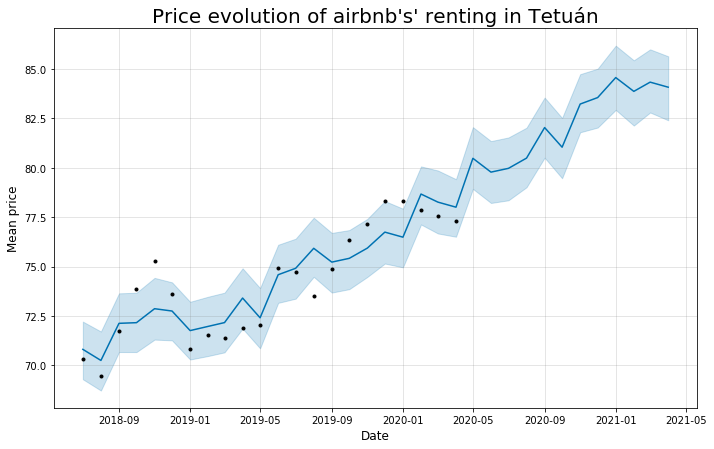

<Figure size 1440x720 with 0 Axes>

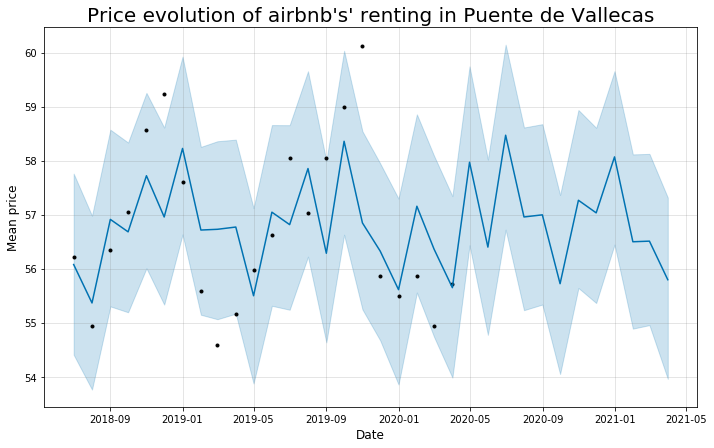

<Figure size 1440x720 with 0 Axes>

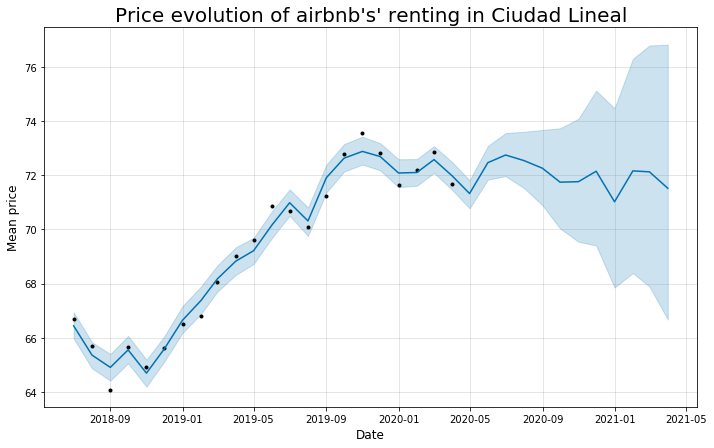

<Figure size 1440x720 with 0 Axes>

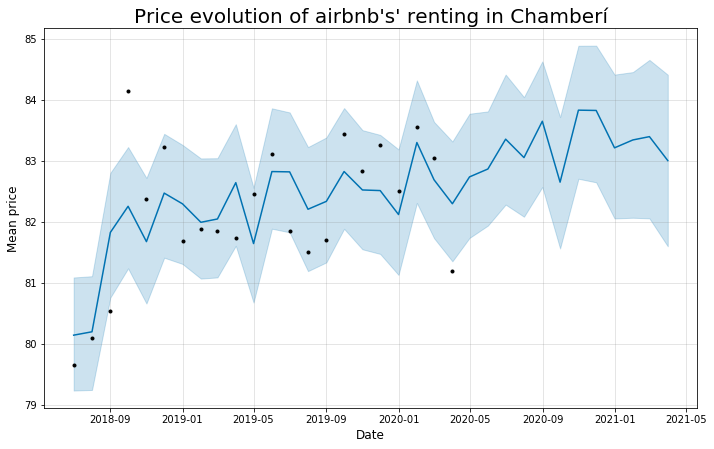

<Figure size 1440x720 with 0 Axes>

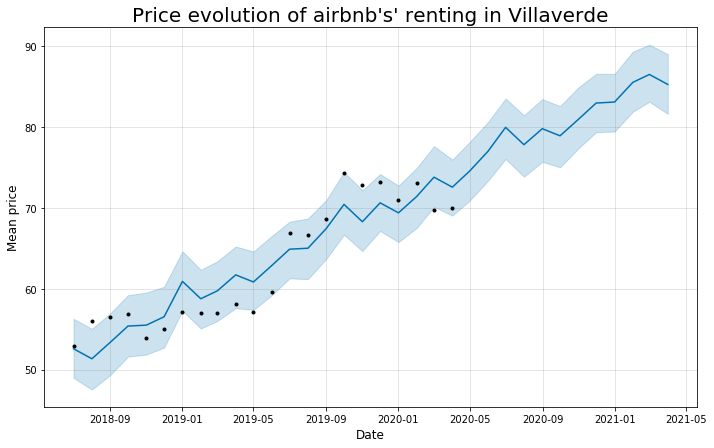

<Figure size 1440x720 with 0 Axes>

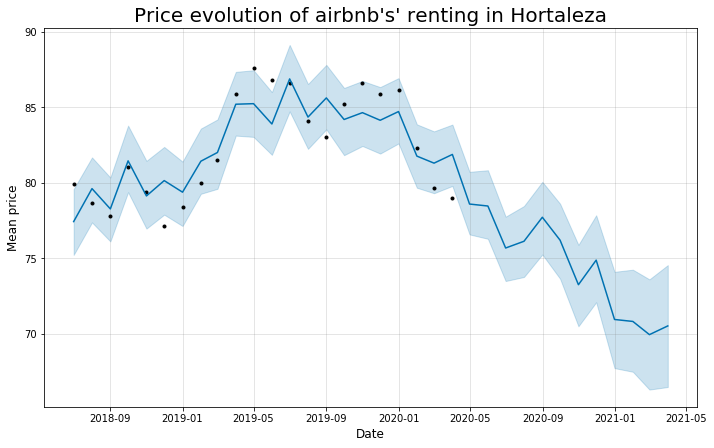

<Figure size 1440x720 with 0 Axes>

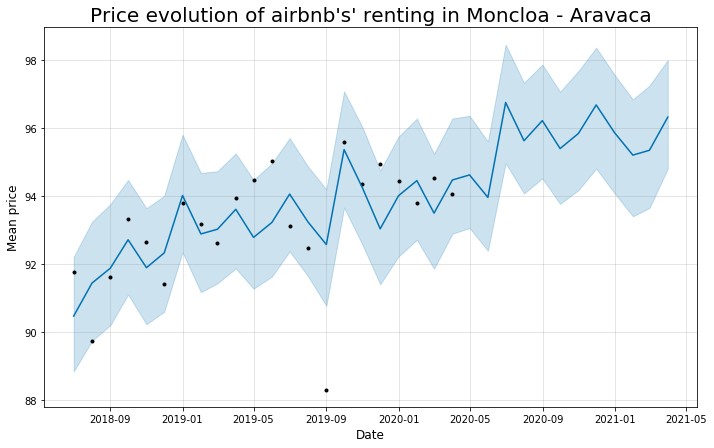

<Figure size 1440x720 with 0 Axes>

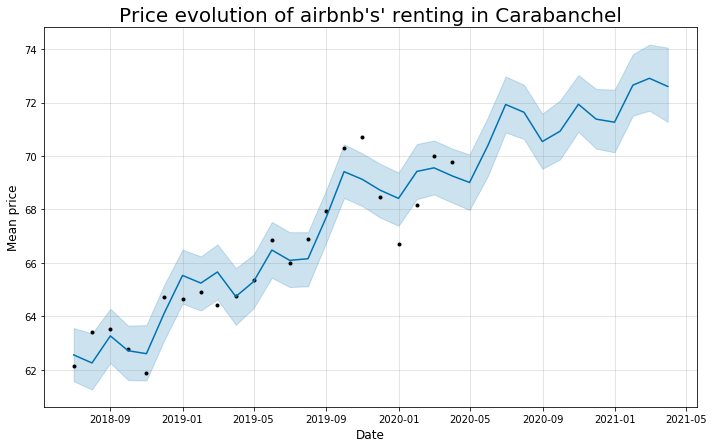

<Figure size 1440x720 with 0 Axes>

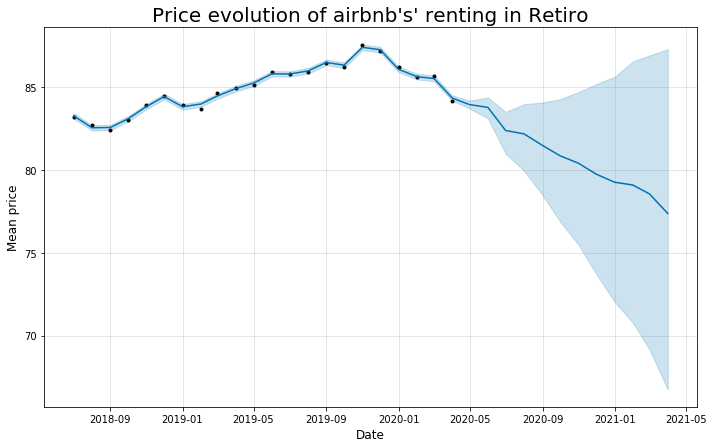

<Figure size 1440x720 with 0 Axes>

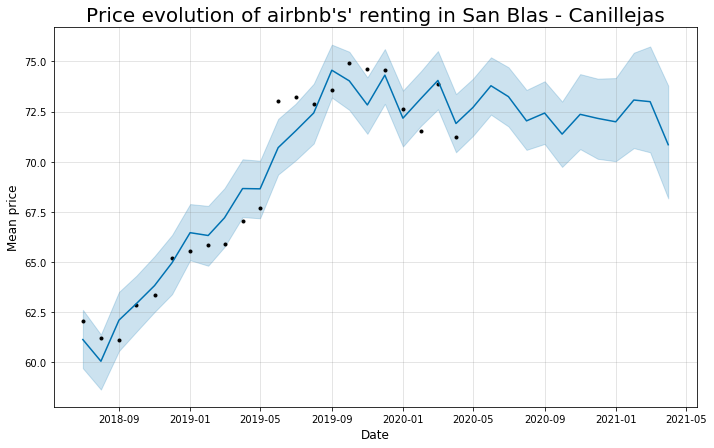

<Figure size 1440x720 with 0 Axes>

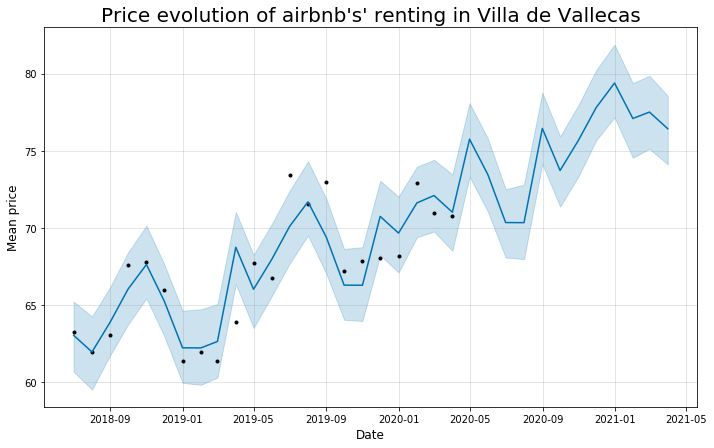

<Figure size 1440x720 with 0 Axes>

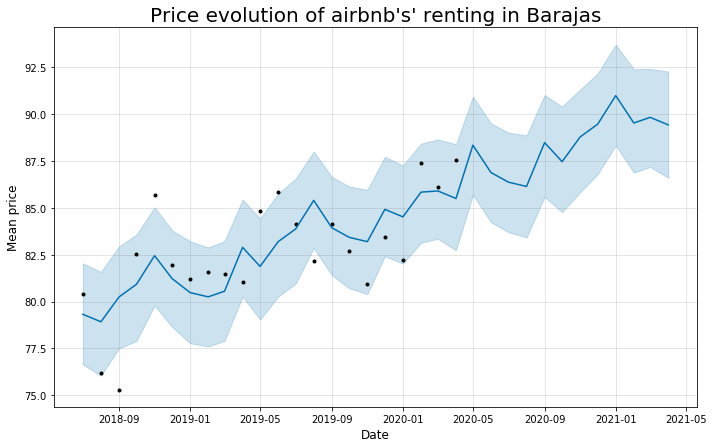

<Figure size 1440x720 with 0 Axes>

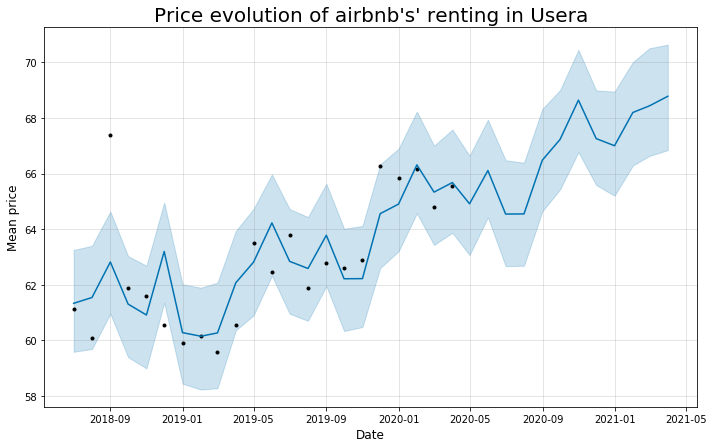

<Figure size 1440x720 with 0 Axes>

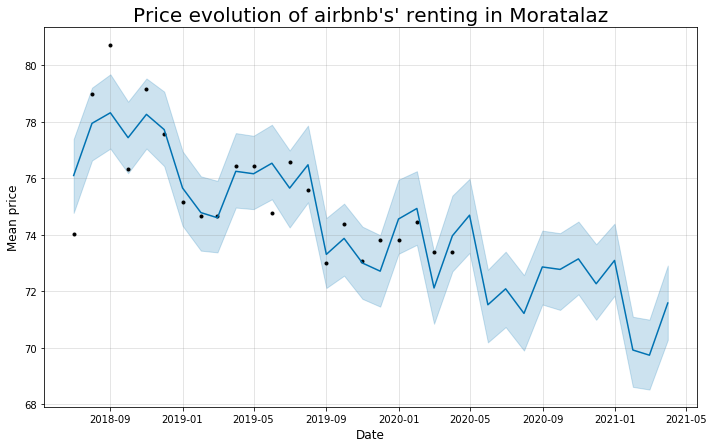

<Figure size 1440x720 with 0 Axes>

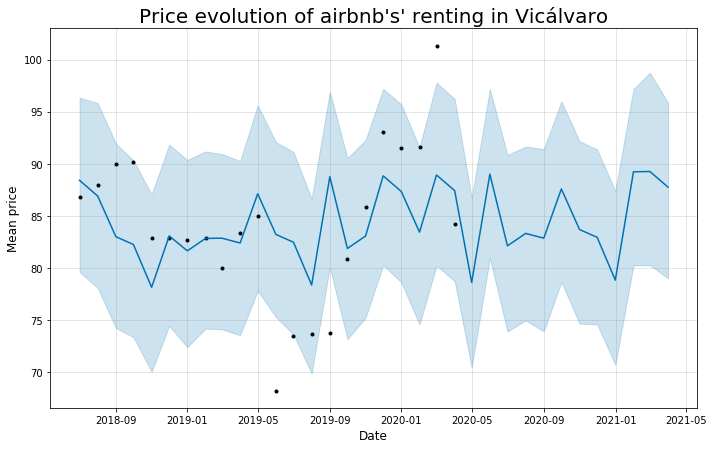

In [98]:
save_path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Proyecto\assets"
fig = plt.figure()
for neig in barrios:
    apt_barrio = apt_dataset[apt_dataset["neighbourhood_group"] == neig]
    apt_barrio = apt_barrio.groupby("date").mean()
    apt_barrio = apt_barrio.reset_index()
    apt_barrio=apt_barrio[['date','value']]
    apt_barrio.dropna(inplace=True)
    apt_barrio = apt_barrio.loc[apt_barrio["date"] > '2018-06-01', :]
    apt_barrio = apt_barrio.loc[apt_barrio["date"] < '2020-05-01', :]
    apt_barrio['ds']=apt_barrio['date']
    apt_barrio['y']=apt_barrio['value']
    apt_barrio.drop(columns = ['date', 'value'], inplace = True)   
    m = Prophet(weekly_seasonality=True)
    m.fit(apt_barrio)
    future_apt_barrio = m.make_future_dataframe(periods=12, 
                                     freq="M") # days for test split
    future_apt_barrio.tail()
    forecast_apt_barrio = m.predict(future_apt_barrio)
    plt.figure(figsize=(20,10))
    fig_apt = m.plot(forecast_apt_barrio)
    plt.title("Price evolution of airbnb's' renting in " + str(neig), {'fontsize': 20})
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Mean price', fontsize=12)
    #plt.savefig("{}.png".format(save_path + "\\" + neig), bbox_inches='tight')
plt.show()

#### Rooms

#### We are going to repeat the analysis but now for the rooms instead of the apartments. Room rental is cheaper so there should be differences:

In [99]:
df_room = room_dataset.groupby("date").mean()
df_room = df_room.reset_index()
df_room=df_room[['date','value']]
df_room.dropna(inplace=True)

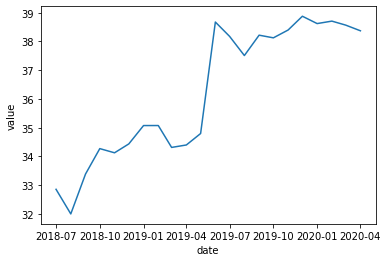

In [100]:
df_room = df_room.loc[df_room["date"] > '2018-06-01', :]
df_room = df_room.loc[df_room["date"] < '2020-05-01', :]
room_plot = sns.lineplot(data=df_room, x="date", y="value")

#### We will use again Prophet to predict now the room's price evolution in Madrid:

Text(66.375, 0.5, 'Mean price')

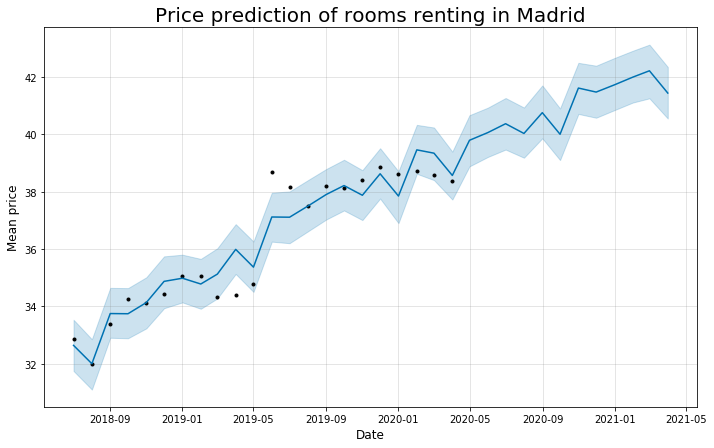

In [101]:
df_room['ds']=df_room['date']
df_room['y']=df_room['value']
df_room.drop(columns = ['date', 'value'], inplace = True)   
# df['cap'] = 8.5
m = Prophet(weekly_seasonality=True)
m.fit(df_room)
future_room = m.make_future_dataframe(periods=12, 
                                 freq="M") # days for test split
future_room.tail()
forecast_room = m.predict(future_room)
fig_room = m.plot(forecast_room)
plt.title('Price prediction of rooms renting in Madrid', {'fontsize': 20})
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean price', fontsize=12)
#plt.savefig("{}.png".format(save_path + "\\room_madrid"), bbox_inches='tight')

#### Let's predict now the room's evolution price per neighbourhood, which should be more precise:

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

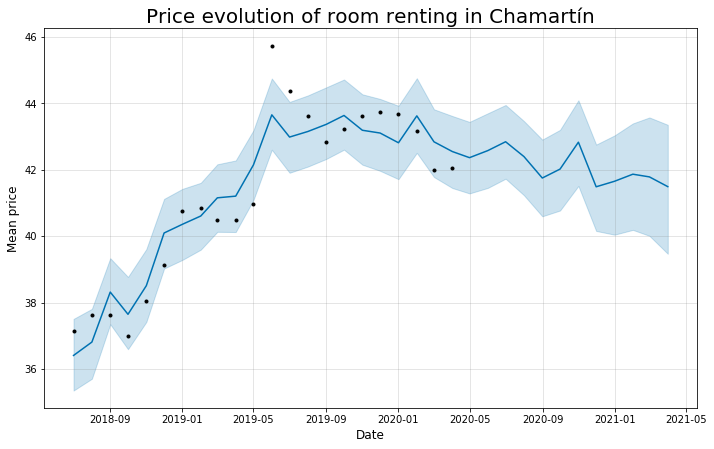

<Figure size 432x288 with 0 Axes>

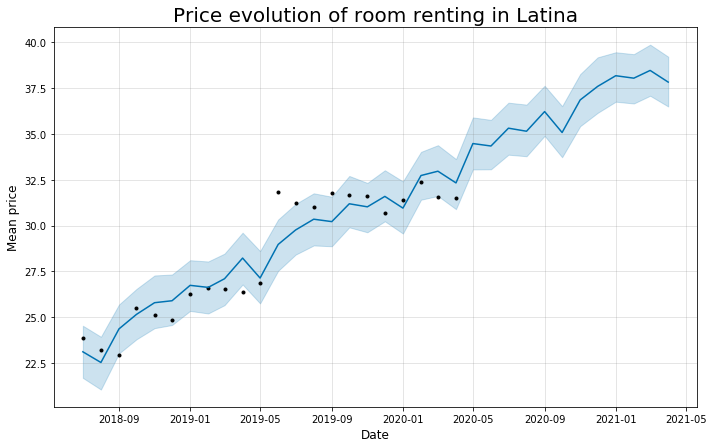

<Figure size 432x288 with 0 Axes>

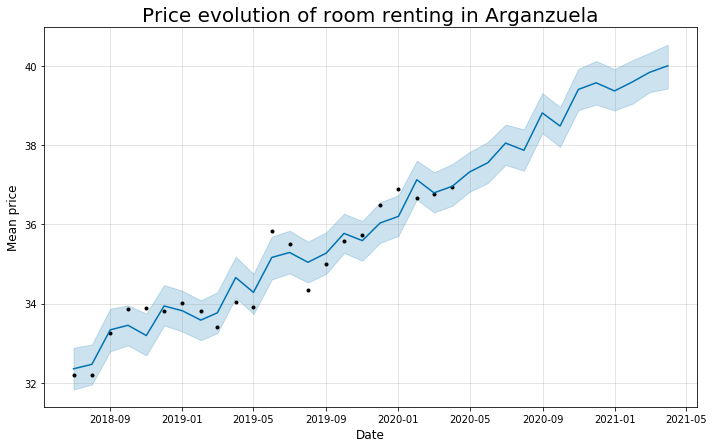

<Figure size 432x288 with 0 Axes>

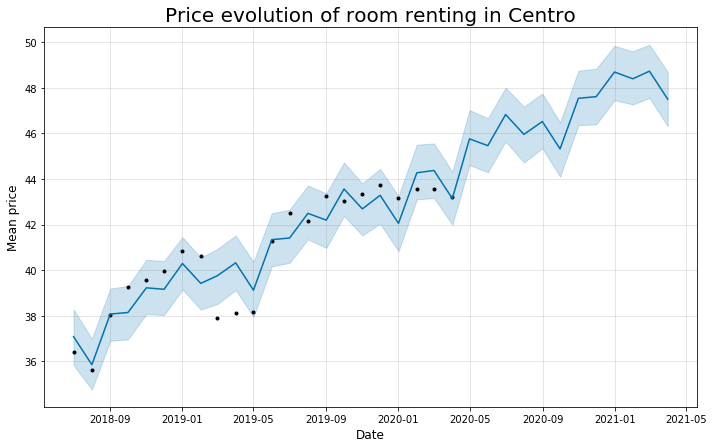

<Figure size 432x288 with 0 Axes>

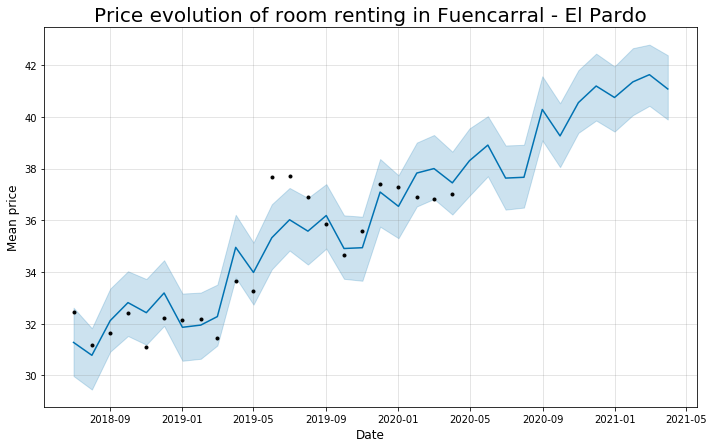

<Figure size 432x288 with 0 Axes>

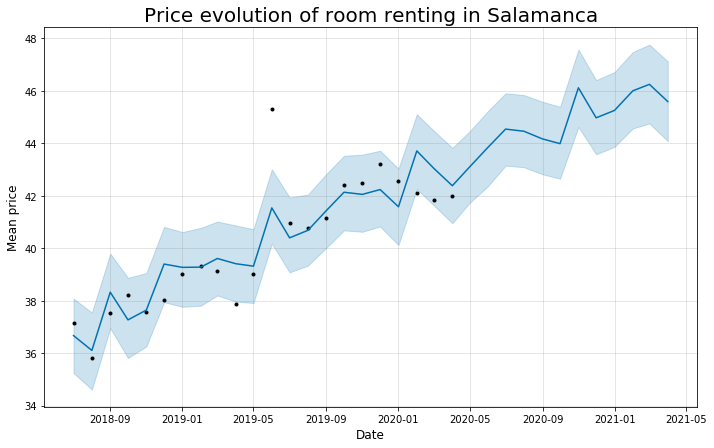

<Figure size 432x288 with 0 Axes>

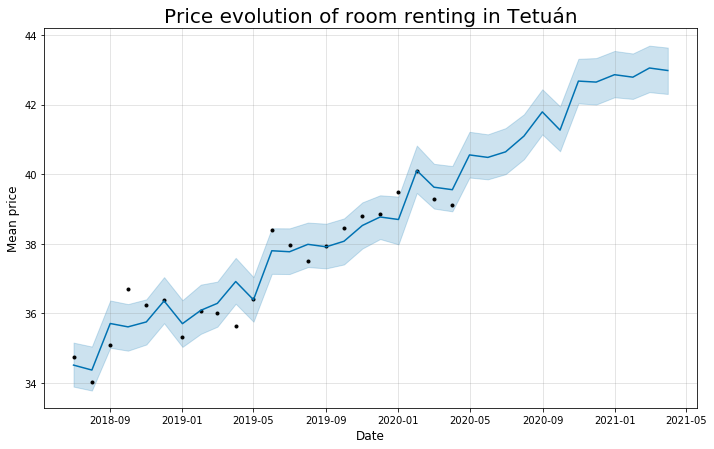

<Figure size 432x288 with 0 Axes>

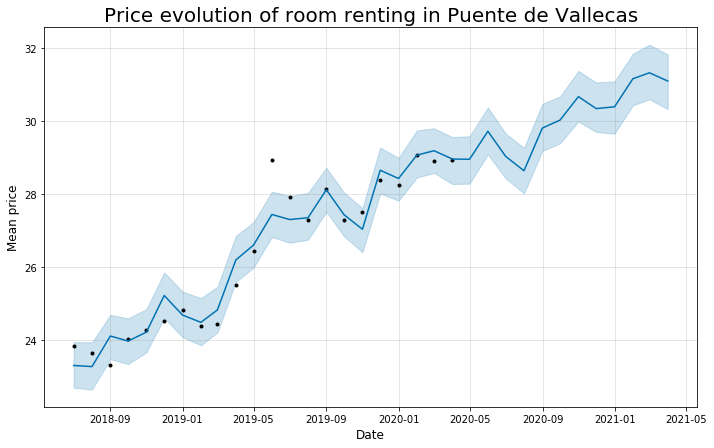

<Figure size 432x288 with 0 Axes>

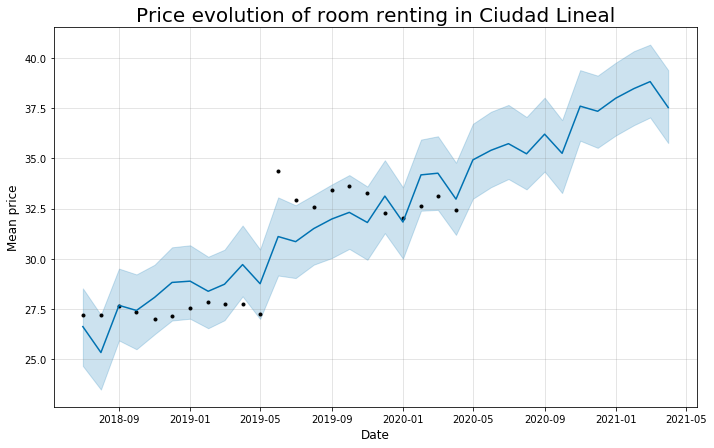

<Figure size 432x288 with 0 Axes>

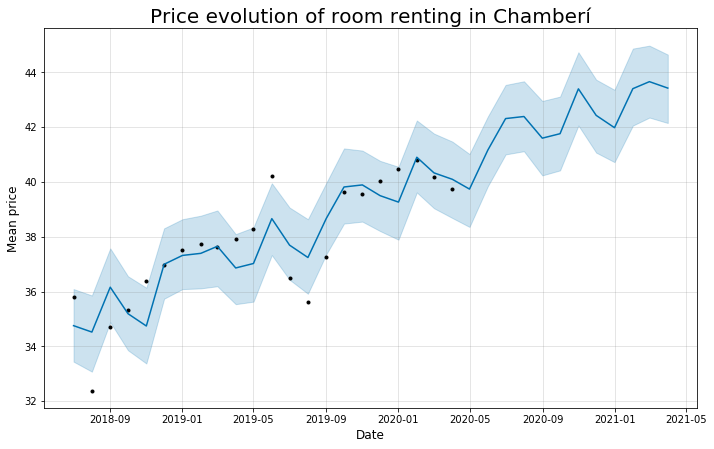

<Figure size 432x288 with 0 Axes>

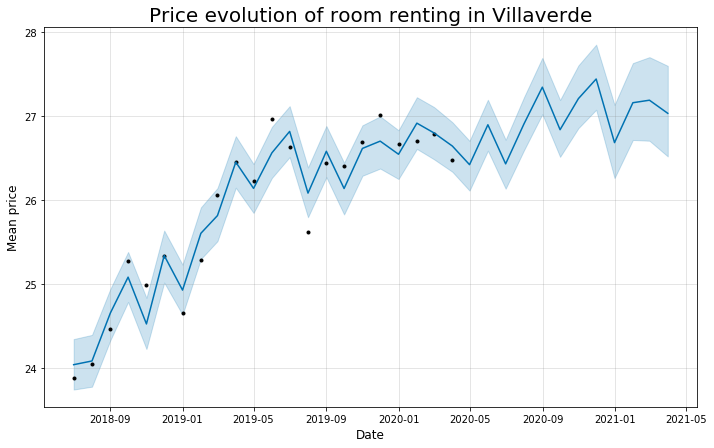

<Figure size 432x288 with 0 Axes>

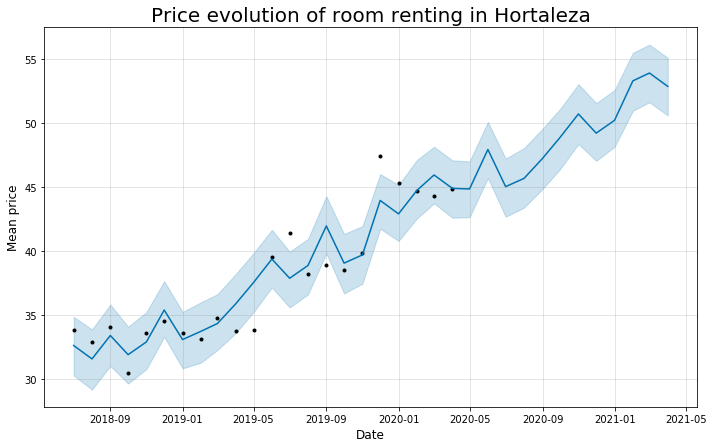

<Figure size 432x288 with 0 Axes>

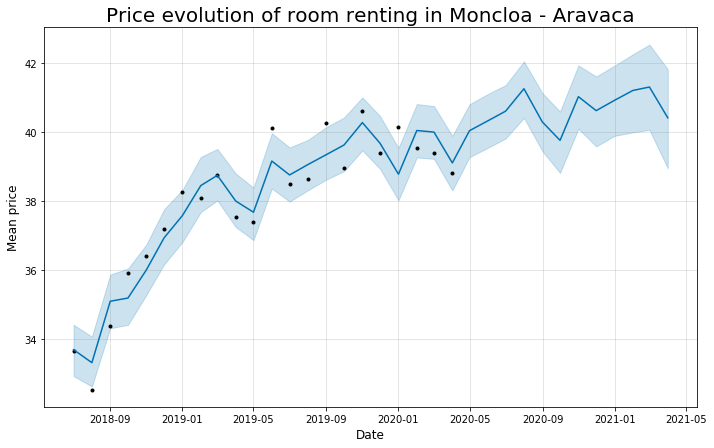

<Figure size 432x288 with 0 Axes>

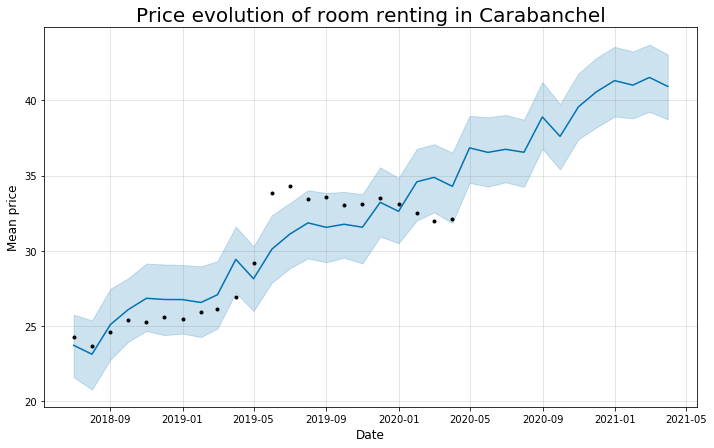

<Figure size 432x288 with 0 Axes>

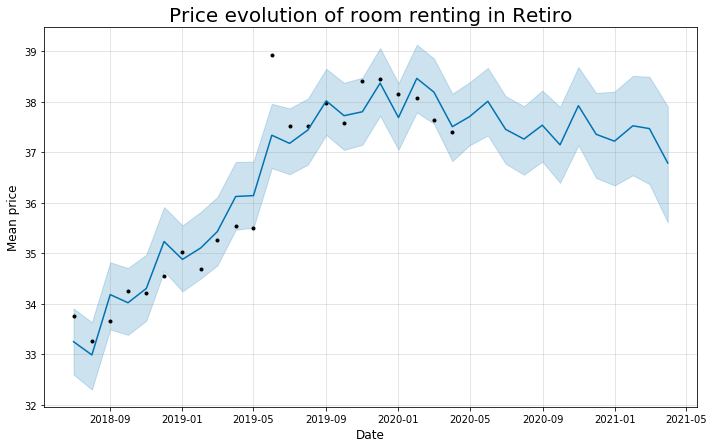

<Figure size 432x288 with 0 Axes>

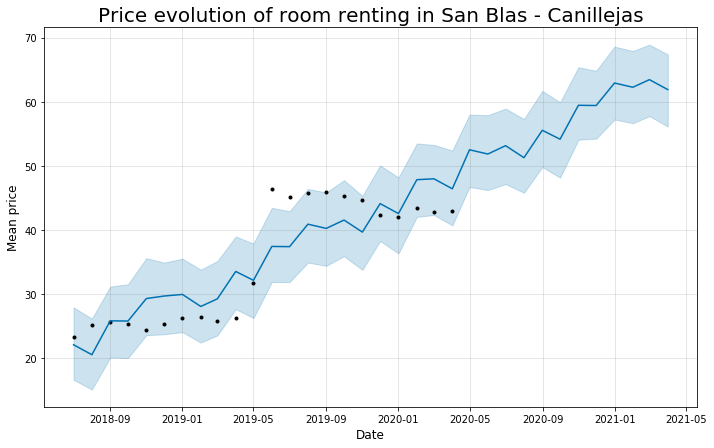

<Figure size 432x288 with 0 Axes>

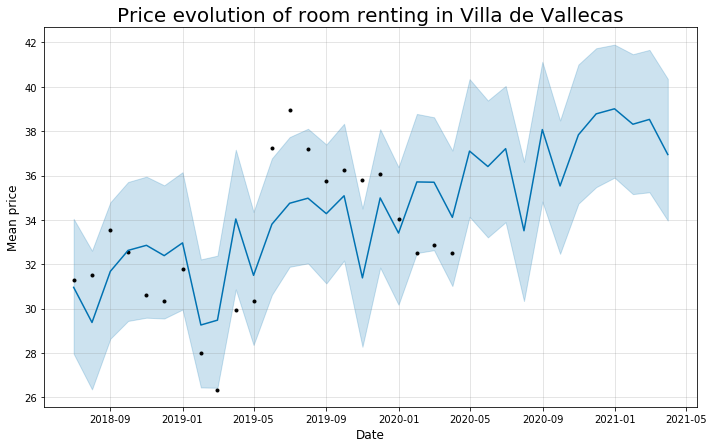

<Figure size 432x288 with 0 Axes>

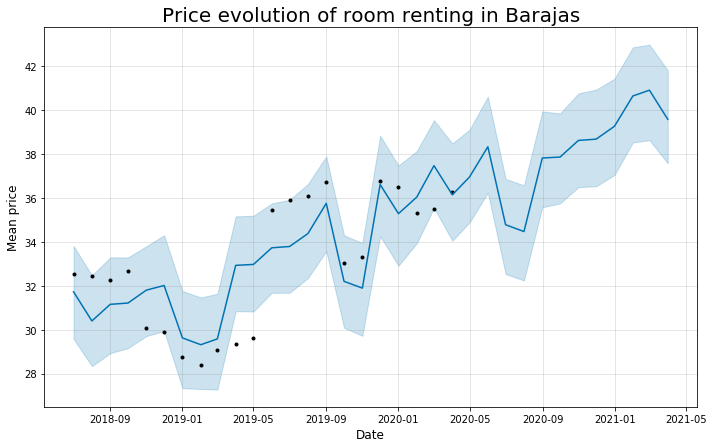

<Figure size 432x288 with 0 Axes>

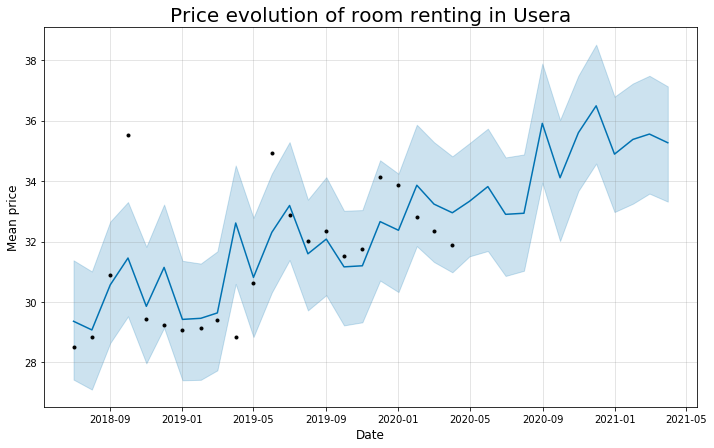

<Figure size 432x288 with 0 Axes>

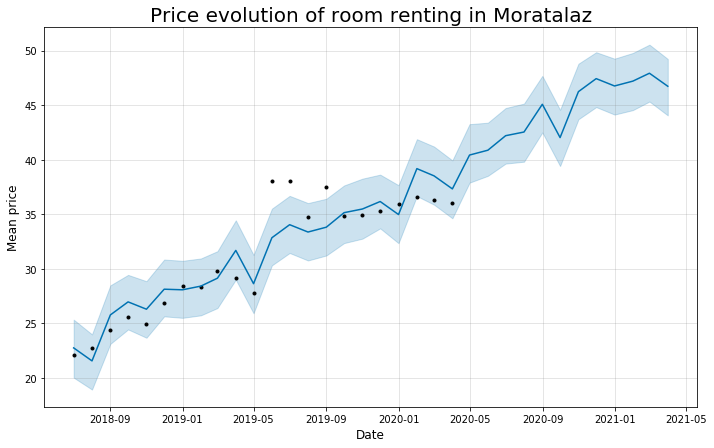

<Figure size 432x288 with 0 Axes>

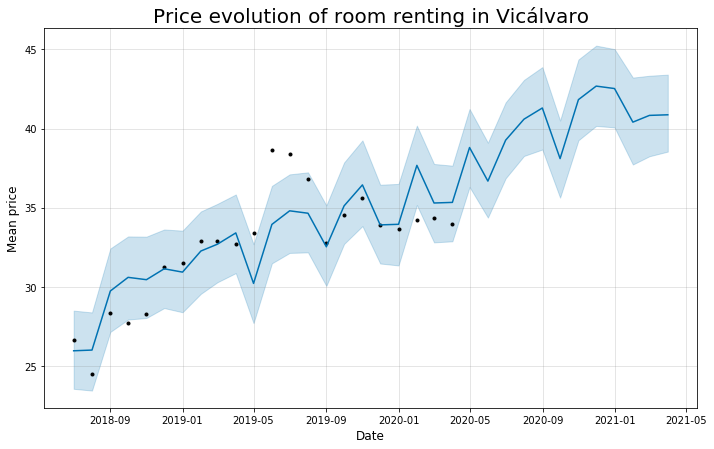

In [102]:
fig = plt.figure()
for neig in barrios:
    room_barrio = room_dataset[room_dataset["neighbourhood_group"] == neig]
    room_barrio = room_barrio.groupby("date").mean()
    room_barrio = room_barrio.reset_index()
    room_barrio=room_barrio[['date','value']]
    room_barrio.dropna(inplace=True)
    room_barrio = room_barrio.loc[room_barrio["date"] > '2018-06-01', :]
    room_barrio = room_barrio.loc[room_barrio["date"] < '2020-05-01', :]
    #prophet expects data in the format as DF('ds','y)
    room_barrio['ds']=room_barrio['date']
    room_barrio['y']=room_barrio['value']
    room_barrio.drop(columns = ['date', 'value'], inplace = True)   
    # df['cap'] = 8.5
    m = Prophet(weekly_seasonality=True)
    m.fit(room_barrio)
    future_room_barrio = m.make_future_dataframe(periods=12, 
                                     freq="M") # days for test split
    future_room_barrio.tail()
    forecast_room_barrio = m.predict(future_room_barrio)
    plt.figure()
    fig_apt = m.plot(forecast_room_barrio)
    plt.title('Price evolution of room renting in ' + str(neig), {'fontsize': 20})
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Mean price', fontsize=12)
plt.show()